### Библиотеки

In [32]:
import math
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from random import random
from scipy.stats import norm, uniform, expon, bernoulli
from scipy import stats
from typing import Dict, List, Tuple, Callable

from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats import norm, expon, t, hypergeom, chi2

### Цетральная Предельная Теорема

Предположим, мы проводим A/B-тестирование и измеряем две метрики для вариантов A и B: коэффициент конверсии C (с какой скоростью люди совершают конверсию) и затраченное время T (сколько минут они проводят в продукте). В обоих случаях наша нулевая гипотеза будет «A и B — одно и то же», что можно перевести на язык математики следующим образом:

$
H_0 (конверсия):  \text{Conv}_A=\text{Conv}_B \\
H_0 (время): \text{Time}_A=\text{Time}_B
$

\\


Здесь важный момент: в приведенном выше выражении $\text{Conv}_A$ и $\text{Conv}_B$— коэффициент конверсии, а $\text{Time}_A$ и $\text{Time}_B$ — среднее количество затраченного времени в минутах. Обе эти величины являются средними: для коэффициента конверсии мы можем представить конверсию как 1, а отсутствие конверсии — как 0, а коэффициент конверсии — это среднее значение этой случайной величины (как подбрасывание монеты). Затраченное время также вычисляется путем сложения отдельных затраченных минут и деления на количество выборок.

И вот в чём ключ: популярные $z$-тест и $t$-тест работает только в том случае, если эти средние значения можно аппроксимировать нормальным распределением. **Поэтому нормальным должно быть не распределение конверсий или распределение затрат времени**. На самом деле, они вообще не подчиняются нормальному распределению! Конверсии представляют собой нули и единицы, подчиняющиеся распределению Бернулли, подобно подбрасыванию монеты. В SaaS-продуктах затраты времени обычно имеют экспоненциальный спад. Но при достаточно большом размере выборки распределение средних значений, вычисленных по выборкам, фактически можно аппроксимировать нормальным распределением. Это гарантирует **Центральная предельная теорема (ЦПТ)**.

**Центра́льные преде́льные теоре́мы (ЦПТ)** — класс теорем в теории вероятностей, утверждающих, что сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно одинаковые масштабы (ни одно из слагаемых не доминирует, не вносит в сумму определяющего вклада), имеет распределение, близкое к нормальному.

Классическая ЦПТ формулируется как

Пусть $ X_1, \cdots X_n$ - последовательность независимых одинаково распределённых случайных величин, имеющих конечные математическое ожидание $\mu$ и дисперсию $\sigma^2$. Тогда

$$
\frac{\sum_{i=1}^n X_i - \mu n}{\sigma \sqrt n} \rightarrow N(0,1) \text{ по распределению при } n \rightarrow \infty
$$

\\

Мы можем это проверить сами с помощью симуляций Монте-Карло:

1. Сначала зададим нашу выборку каким-нибудь распределением со средним $\mu$.
2. Затем берем `sample_size` объектов и считаем среднее.
3. Делаем шаг 2 `num_sample` раз, так чтобы у нас было `num_sample` средних.
4. Строим распределение средних, и согласно ЦПТ должны увидеть распределение "колокол" с центром в $\mu$.

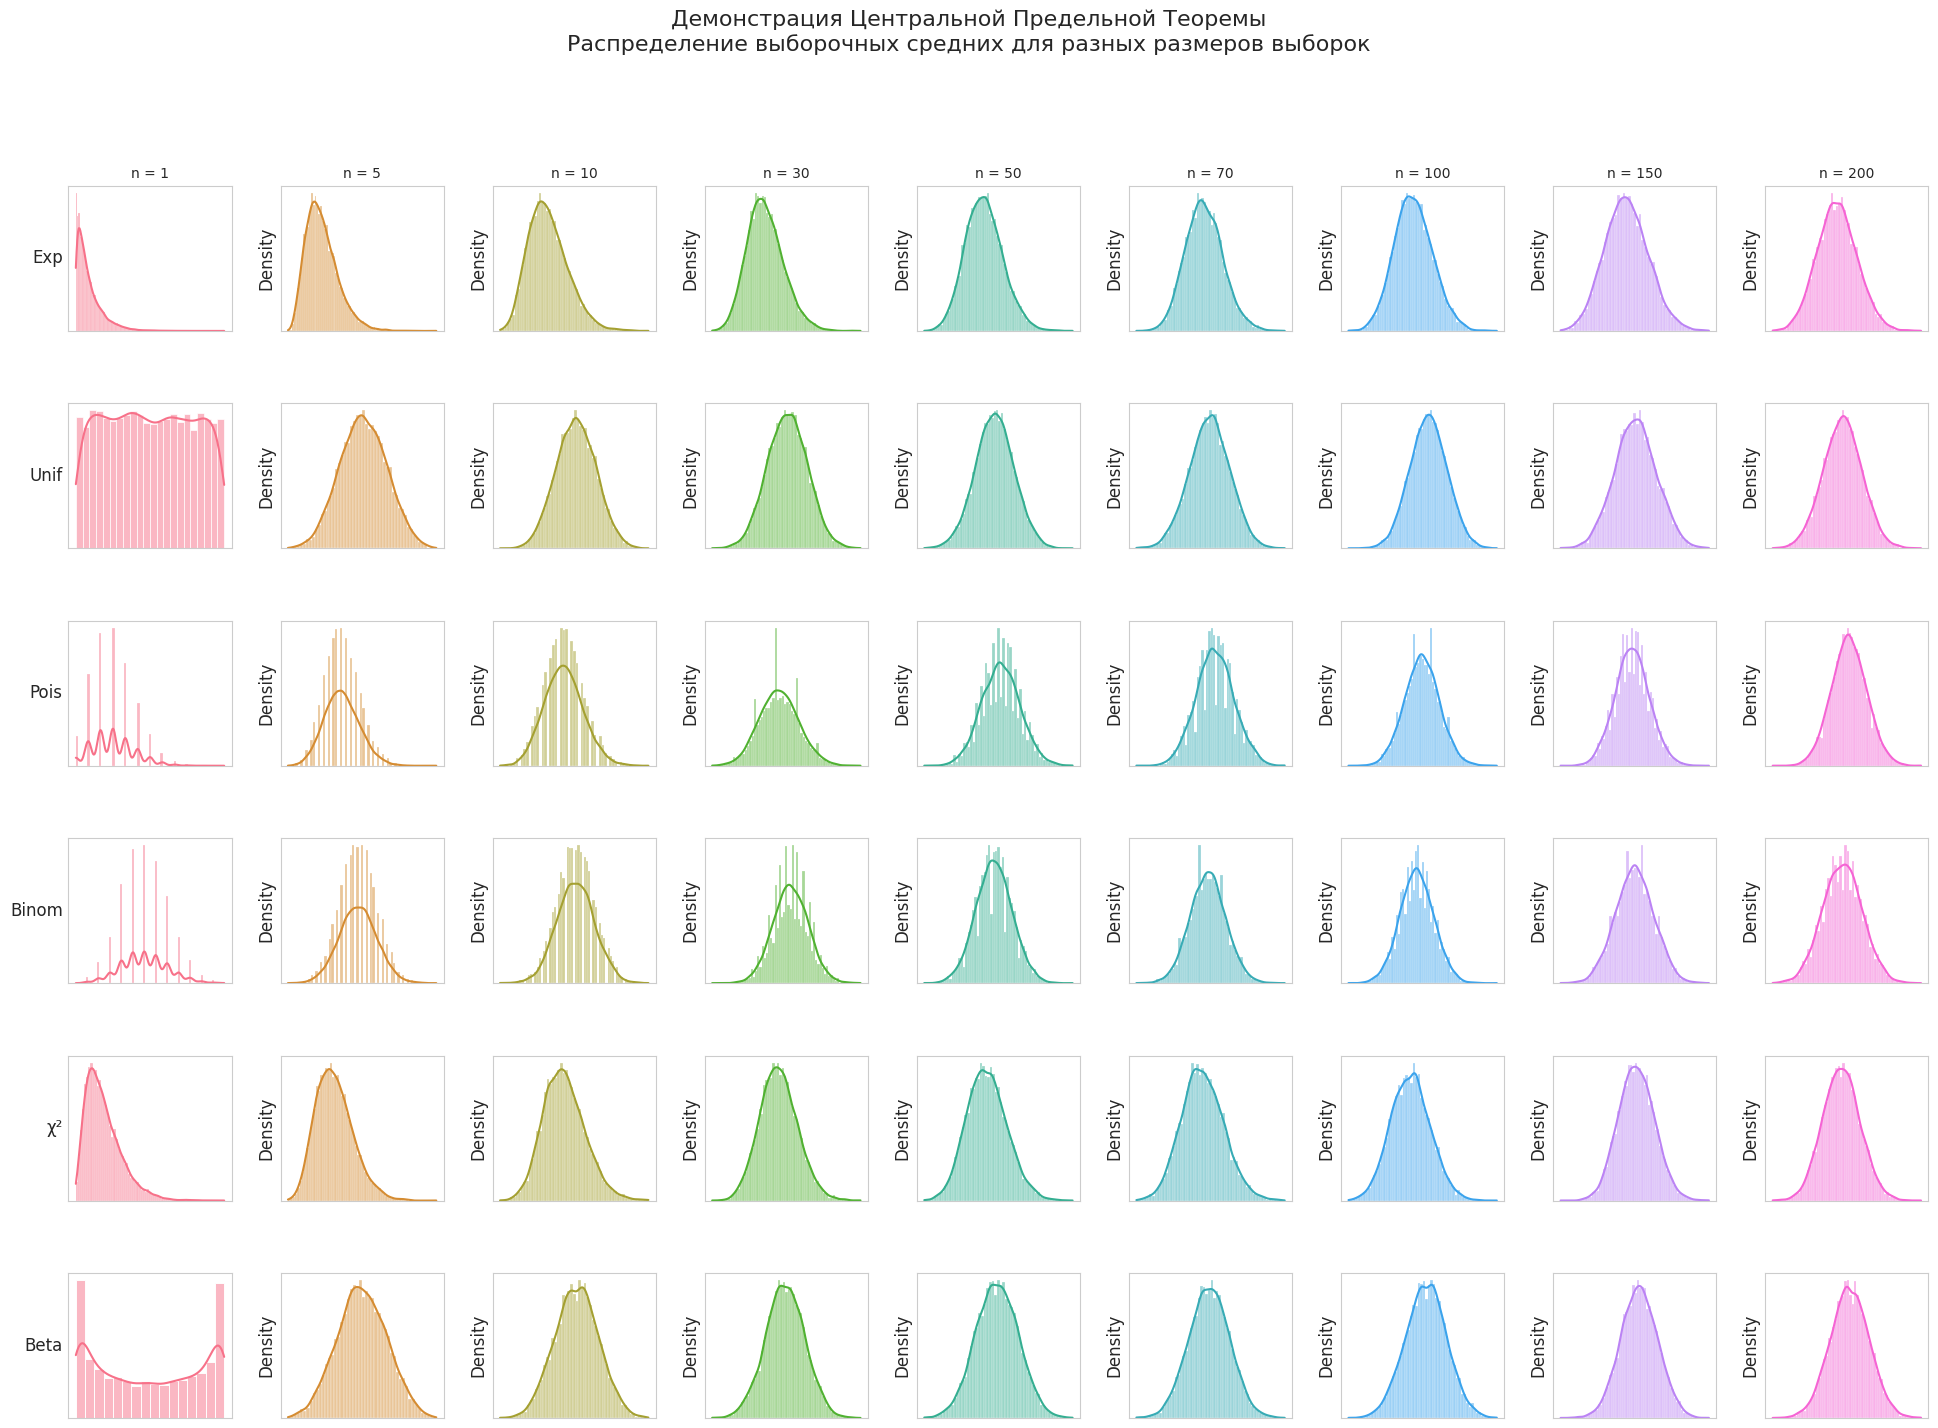

In [10]:
# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (24, 16)
plt.rcParams['font.size'] = 12
COLORS = sns.color_palette("husl", 9)

def generate_distribution(dist_type: str, params: Dict[str, float], size: int) -> np.ndarray:
    """Генерирует выборку из заданного распределения"""
    generators = {
        'exponential': lambda: np.random.exponential(params.get('scale', 1.0), size),
        'uniform': lambda: np.random.uniform(params.get('low', 0), params.get('high', 1), size),
        'poisson': lambda: np.random.poisson(params.get('lam', 5), size),
        'binomial': lambda: np.random.binomial(params.get('n', 10), params.get('p', 0.5), size),
        'chi2': lambda: np.random.chisquare(params.get('df', 2), size),
        'beta': lambda: np.random.beta(params.get('a', 2), params.get('b', 5), size),
    }
    return generators[dist_type]()

def calculate_theoretical_params(dist_type: str, params: Dict[str, float]) -> Tuple[float, float]:
    """Вычисляет теоретические среднее и стандартное отклонение"""
    if dist_type == 'exponential':
        mean = params.get('scale', 1.0)
        std = mean
    elif dist_type == 'uniform':
        low, high = params.get('low', 0), params.get('high', 1)
        mean, std = (low+high)/2, np.sqrt((high-low)**2/12)
    elif dist_type == 'poisson':
        mean = std = np.sqrt(params.get('lam', 5))
    elif dist_type == 'binomial':
        n, p = params.get('n', 10), params.get('p', 0.5)
        mean, std = n*p, np.sqrt(n*p*(1-p))
    elif dist_type == 'chi2':
        df = params.get('df', 2)
        mean, std = df, np.sqrt(2*df)
    elif dist_type == 'beta':
        a, b = params.get('a', 2), params.get('b', 5)
        mean = a/(a+b)
        std = np.sqrt(a*b/((a+b)**2*(a+b+1)))
    return mean, std

def plot_clt_grid():
    """Создает сетку 6x9 графиков для демонстрации ЦПТ"""
    distributions = [
        ('exponential', {'scale': 2.0}),
        ('uniform', {'low': 0, 'high': 10}),
        ('poisson', {'lam': 3}),
        ('binomial', {'n': 20, 'p': 0.3}),
        ('chi2', {'df': 5}),
        ('beta', {'a': 0.5, 'b': 0.5})
    ]
    sample_sizes = [1, 5, 10, 30, 50, 70, 100, 150, 200]
    num_samples = 10000

    fig, axes = plt.subplots(6, 9, figsize=(24, 16))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for row, (dist_type, params) in enumerate(distributions):
        mean, std = calculate_theoretical_params(dist_type, params)

        for col, n in enumerate(sample_sizes):
            ax = axes[row, col]

            # Генерация выборочных средних
            sample_means = np.array([np.mean(generate_distribution(dist_type, params, n))
                                   for _ in range(num_samples)])

            # Построение гистограммы
            sns.histplot(sample_means, ax=ax, kde=True, color=COLORS[col], stat='density')

            # Настройка отображения
            if row == 0:
                ax.set_title(f"n = {n}", fontsize=10)
            if col == 0:
                dist_name = {
                    'exponential': 'Exp',
                    'uniform': 'Unif',
                    'poisson': 'Pois',
                    'binomial': 'Binom',
                    'chi2': 'χ²',
                    'beta': 'Beta'
                }[dist_type]
                ax.set_ylabel(dist_name, fontsize=12, rotation=0, ha='right', va='center')

            ax.set_xticks([])
            ax.set_yticks([])

    plt.suptitle("Демонстрация Центральной Предельной Теоремы\nРаспределение выборочных средних для разных размеров выборок",
                fontsize=16, y=0.99)
    plt.show()


plot_clt_grid()

###Кейс применения $z$-теста

Интернет-магазин хочет протестировать новую версию чекаута (страницы оформления заказа). В текущем варианте средняя конверсия в покупку с чекаута 70%. Владелец продукта хочет, чтобы конверсия увеличилася хотя бы на 1%. Новый вариант довольно новый, поэтому для предосторожности он хочет, чтобы всего лишь 20% пользователей на странице видели новую версию.


**Задачи**
1. Оценить необходимый размер выборки
2. Провести тест и проинтерпретировать выводы
3. Проверить, контролирует ли тест и критерий ошибки 1 и 2 рода
4. Предположите, какими будут зависимости размера выборки от
  * распределения по группам (10/90, 20/80, 30/70 ...)
  * значения ошибки 1 рода
  * значения ошибки 2 рода
  * разницы в значениях конверсий
  * изначального значения базовой конверсии
5. Постройте распределения и проверьте догадки

In [29]:
def alpha_to_z(alpha: float, one_sided: bool) -> float:
    """
    Конвертирует уровень значимости (alpha) в Z-оценку

    Параметры:
        alpha: Уровень значимости (вероятность ошибки I рода)
        one_sided: Флаг одностороннего теста

    Возвращает:
        Z-оценку, соответствующую заданному уровню значимости
    """
    pos = 1 - alpha if one_sided else 1 - alpha/2.0
    return norm.ppf(pos)

def power_to_z(power: float) -> float:
    """
    Конвертирует мощность теста в Z-оценку

    Параметры:
        power: Мощность теста (1 - вероятность ошибки II рода)

    Возвращает:
        Z-оценку, соответствующую заданной мощности
    """
    return norm.ppf(power)

def z_to_p(z: float, one_sided: bool) -> float:
    """
    Конвертирует Z-оценку в p-значение

    Параметры:
        z: Z-оценка
        one_sided: Флаг одностороннего теста

    Возвращает:
        p-значение для заданной Z-оценки
    """
    p = 1 - norm.cdf(z)
    return p if one_sided else 2*p

def calculate_required_sample_size(
    alpha: float,
    base_conversion: float,
    expected_improvement: float,
    traffic_ratio_A: float,
    power: float = 0.80,
    one_sided: bool = True
) -> int:
    """
    Рассчитывает необходимый размер выборки для A/B-теста

    Параметры:
        alpha: Уровень значимости
        base_conversion: Базовый уровень конверсии (вариант A)
        expected_improvement: Ожидаемое улучшение конверсии
        traffic_ratio_A: Доля трафика, идущего в вариант A
        power: Мощность теста (по умолчанию 0.8)
        one_sided: Флаг одностороннего теста (по умолчанию True)

    Возвращает:
        Минимальный размер выборки для двух группы
    """
    z_alpha = alpha_to_z(alpha, one_sided)
    z_power = power_to_z(power)
    conversion_B = base_conversion + expected_improvement
    traffic_ratio_B = 1 - traffic_ratio_A

    variance_A = base_conversion * (1 - base_conversion) / traffic_ratio_A
    variance_B = conversion_B * (1 - conversion_B) / traffic_ratio_B
    effect_size = (base_conversion - conversion_B) ** 2

    N = (variance_A + variance_B) * ((z_alpha + z_power) ** 2) / effect_size
    return math.ceil(N)

def assign_user_to_group(
    user_id: int,
    traffic_split: float,
    test_seed: str
) -> str:
    """
    Случайно распределяет пользователя в группу A или B

    Параметры:
        user_id: Уникальный идентификатор пользователя
        traffic_split: Доля трафика для группы A (0-1)
        test_seed: Строка-сид для воспроизводимости

    Возвращает:
        'A' или 'B' - назначенная группа
    """
    test_id = hashlib.md5(test_seed.encode() + str(user_id).encode()).hexdigest()
    bits = bin(int(test_id, 16))[3:]
    r = sum(int(bit) * (0.5 ** (i + 1)) for i, bit in enumerate(bits))
    return 'A' if r < traffic_split else 'B'

def run_ab_test(
    sample_size: int,
    conversion_rates: Dict[str, float],
    user_assignment_func: Callable[[int], str]
) -> Dict[str, Dict[str, int]]:
    """
    Проводит A/B-тест с заданными параметрами

    Параметры:
        sample_size: Общий размер выборки
        conversion_rates: Словарь с реальными конверсиями {'A': 0.1, 'B': 0.11}
        user_assignment_func: Функция распределения пользователей

    Возвращает:
        Словарь с результатами теста
    """
    results = {'A': {'users': 0, 'conversions': 0},
               'B': {'users': 0, 'conversions': 0}}

    for user_id in range(sample_size):
        group = user_assignment_func(user_id)
        results[group]['users'] += 1
        if random() < conversion_rates[group]:
            results[group]['conversions'] += 1

    return results

def calculate_p_value(
    group_A_results: Dict[str, int],
    group_B_results: Dict[str, int],
    one_sided: bool = True
) -> float:
    """
    Рассчитывает p-значение для результатов A/B-теста

    Параметры:
        group_A_results: Результаты группы A {'users': N, 'conversions': X}
        group_B_results: Результаты группы B {'users': M, 'conversions': Y}
        one_sided: Флаг одностороннего теста

    Возвращает:
        p-значение
    """
    conversion_A = group_A_results['conversions'] / group_A_results['users']
    conversion_B = group_B_results['conversions'] / group_B_results['users']

    var_A = conversion_A * (1 - conversion_A) / group_A_results['users']
    var_B = conversion_B * (1 - conversion_B) / group_B_results['users']

    z_score = (conversion_B - conversion_A) / math.sqrt(var_A + var_B)
    return z_to_p(z_score, one_sided)


# Параметры теста
TEST_PARAMS = {
    'alpha': 0.05,               # Уровень значимости
    'power': 0.80,               # Мощность теста
    'base_conversion': 0.70,     # Конверсия текущей версии (A)
    'expected_improvement': 0.01,# Ожидаемое улучшение (абсолютное значение)
    'traffic_split': 0.80,       # Доля трафика для группы A
    'test_seed': 'OkMdZa18pfr8m5sy2IL52pW9ol2EpLekgakJAIZFBbgZ'
}

# Реальные конверсии (обычно неизвестны до проведения теста)
REAL_CONVERSIONS = {
    'A': 0.70,  # Фактическая конверсия группы A
    'B': 0.715   # Фактическая конверсия группы B
}

# 1. Расчет необходимого размера выборки
min_sample_size = calculate_required_sample_size(
    alpha=TEST_PARAMS['alpha'],
    base_conversion=TEST_PARAMS['base_conversion'],
    expected_improvement=TEST_PARAMS['expected_improvement'],
    traffic_ratio_A=TEST_PARAMS['traffic_split'],
    power=TEST_PARAMS['power']
)

print(f"Минимальный размер выборки: {round(min_sample_size / 2)}")


# 2. Проведение A/B-теста
test_results = run_ab_test(
    sample_size=min_sample_size,
    conversion_rates=REAL_CONVERSIONS,
    user_assignment_func=lambda uid: assign_user_to_group(
        uid, TEST_PARAMS['traffic_split'], TEST_PARAMS['test_seed'])
)

# 3. Анализ результатов
conversion_A = test_results['A']['conversions'] / test_results['A']['users']
conversion_B = test_results['B']['conversions'] / test_results['B']['users']

print("\nРезультаты теста:")
print(f"Группа A: {test_results['A']['users']} пользователей, "
      f"{test_results['A']['conversions']} конверсий ({conversion_A:.3%})")
print(f"Группа B: {test_results['B']['users']} пользователей, "
      f"{test_results['B']['conversions']} конверсий ({conversion_B:.3%})")

p_value = calculate_p_value(test_results['A'], test_results['B'])
print(f"\np-значение: {p_value:.4f}")

# 4. Принятие решения
if p_value <= TEST_PARAMS['alpha']:
    print("\nЗаключение: Разница статистически значима. Можно внедрять вариант B.")
else:
    print("\nЗаключение: Разница не статистически значима. Оставляем вариант A.")

Минимальный размер выборки: 39940

Результаты теста:
Группа A: 63880 пользователей, 44853 конверсий (70.214%)
Группа B: 15999 пользователей, 11449 конверсий (71.561%)

p-значение: 0.0004

Заключение: Разница статистически значима. Можно внедрять вариант B.


In [38]:
def simulate_error_rates(
    num_tests: int,
    sample_size: int,
    base_conversion: float,
    expected_improvement: float,
    traffic_split: float,
    test_seed: str,
    alpha: float,
    one_sided: bool = True
) -> Tuple[float, float]:
    """
    Прогоняет num_tests симуляций A/A и A/B и возвращает:
      - фактическую долю ложноположительных (тип I error)
      - фактическую долю ложноотрицательных (тип II error)
    """
    false_positives = 0  # A/A: мы не ожидаем различий → любая значимость = ошибка I рода
    false_negatives = 0  # A/B: мы ожидаем улучшение → p>alpha = ошибка II рода

    for i in tqdm(range(num_tests)):
        # --- 1) A/A тест ---
        # Две группы с одинаковой конверсией = base_conversion

        # Группировка так же по md5(+ тэг), чтобы группы были детерминированы
        user_assign_aa = lambda uid: assign_user_to_group(uid, traffic_split, test_seed)
        results_aa = run_ab_test(
            sample_size=sample_size,
            conversion_rates={'A': base_conversion, 'B': base_conversion},
            user_assignment_func=user_assign_aa
        )
        p_aa = calculate_p_value(results_aa['A'], results_aa['B'], one_sided=one_sided)
        if p_aa <= alpha:
            false_positives += 1

        # --- 2) A/B тест ---
        user_assign_ab = lambda uid: assign_user_to_group(uid, traffic_split, test_seed)
        results_ab = run_ab_test(
            sample_size=sample_size,
            conversion_rates={
                'A': base_conversion,
                'B': base_conversion + expected_improvement
            },
            user_assignment_func=user_assign_ab
        )
        p_ab = calculate_p_value(results_ab['A'], results_ab['B'], one_sided=one_sided)
        # если p > alpha — мы НЕ заметили реальную разницу → ошибка II рода
        if p_ab > alpha:
            false_negatives += 1

    type1_rate = false_positives / num_tests
    type2_rate = false_negatives / num_tests
    return type1_rate, type2_rate


if __name__ == "__main__":
    # Ваши TEST_PARAMS и REAL_CONVERSIONS из основного кода
    TEST_PARAMS.update({'one_sided': True})  # добавить, если ещё нет
    # --- 1) Расчёт размера ---
    N = calculate_required_sample_size(
        alpha=TEST_PARAMS['alpha'],
        base_conversion=TEST_PARAMS['base_conversion'],
        expected_improvement=TEST_PARAMS['expected_improvement'],
        traffic_ratio_A=TEST_PARAMS['traffic_split'],
        power=TEST_PARAMS['power'],
        one_sided=TEST_PARAMS['one_sided']
    )
    print(f"Минимальный размер выборки (общее N): {N}")

    # --- 2) Запуск симуляций ошибок ---
    NUM_SIM = 100
    type1, type2 = simulate_error_rates(
        num_tests=NUM_SIM,
        sample_size=N,
        base_conversion=TEST_PARAMS['base_conversion'],
        expected_improvement=TEST_PARAMS['expected_improvement'],
        traffic_split=TEST_PARAMS['traffic_split'],
        test_seed=TEST_PARAMS['test_seed'],
        alpha=TEST_PARAMS['alpha'],
        one_sided=TEST_PARAMS['one_sided']
    )

    print(f"\nПо {NUM_SIM} симуляциям:")
    print(f"Наблюдаемая частота ошибки I рода (A/A → false positive): {type1:.3%} (ожидали ≈ {TEST_PARAMS['alpha']:.1%})")
    print(f"Наблюдаемая частота ошибки II рода (A/B → false negative): {type2:.3%} (ожидали ≈ {1-TEST_PARAMS['power']:.1%})")

Минимальный размер выборки (общее N): 79879


100%|██████████| 100/100 [10:32<00:00,  6.32s/it]


По 100 симуляциям:
Наблюдаемая частота ошибки I рода (A/A → false positive): 1.000% (ожидали ≈ 5.0%)
Наблюдаемая частота ошибки II рода (A/B → false negative): 28.000% (ожидали ≈ 20.0%)


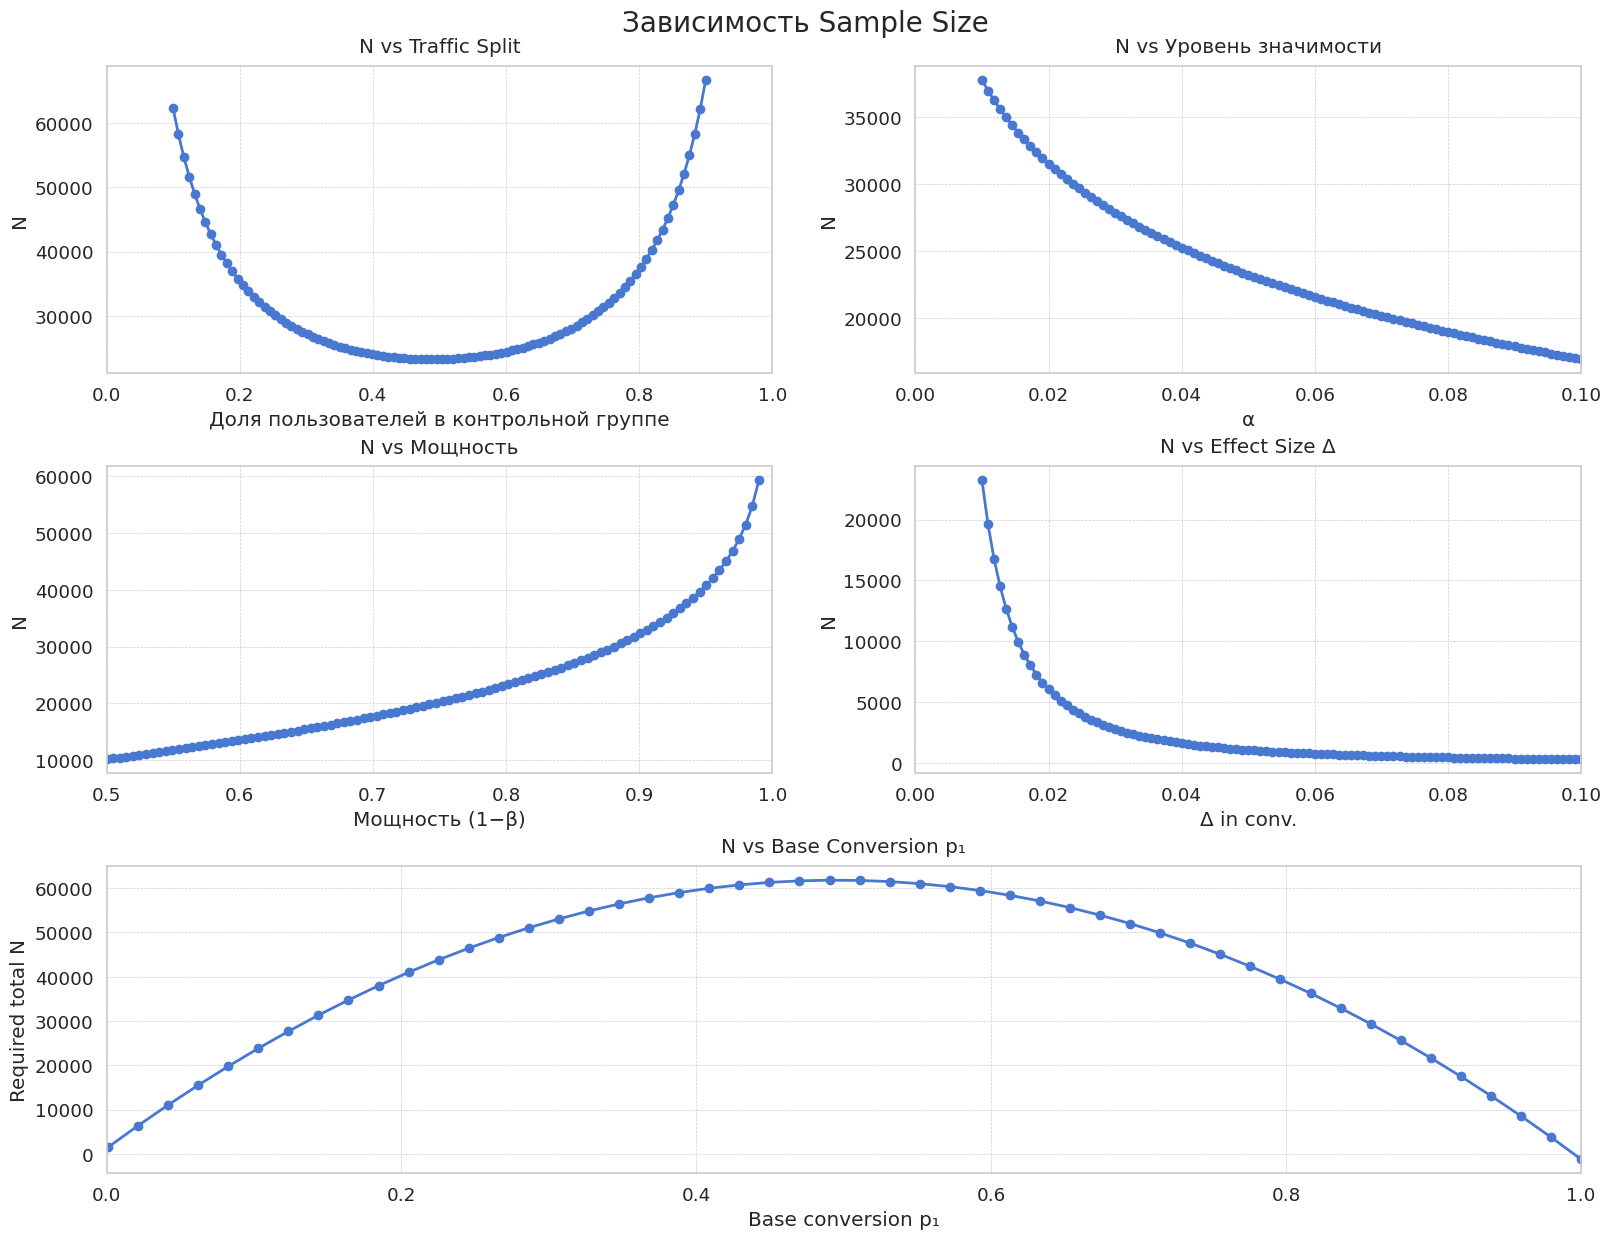

In [45]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

def plot_all_dependencies(
    base_conversion: float = 0.10,
    traffic_splits: np.ndarray = None,
    alphas: list = None,
    powers: list = None,
    deltas: list = None,
    one_sided: bool = True
):
    # Генерируем сетки параметров, если не переданы
    if traffic_splits is None:
        traffic_splits = np.linspace(0.10, 0.90, 100)
    if alphas is None:
        alphas = np.linspace(0.01, 0.10, 100)
    if powers is None:
        powers = np.linspace(0.50, 0.99, 100)
    if deltas is None:
        deltas = np.linspace(0.01, 0.10, 100)

    # Фиксированные значения для «остальных» параметров
    FIX_ALPHA = 0.05
    FIX_POWER = 0.8
    FIX_DELTA = 0.01
    FIX_SPLIT = 0.5

    # Считаем зависимости
    x1, y1 = compute_n_vs_traffic(traffic_splits, base_conversion,
                                  FIX_DELTA, FIX_ALPHA,
                                  FIX_POWER, one_sided)
    x2, y2 = compute_n_vs_alpha(alphas, base_conversion,
                                FIX_DELTA, FIX_SPLIT,
                                FIX_POWER, one_sided)
    x3, y3 = compute_n_vs_power(powers, base_conversion,
                                FIX_DELTA, FIX_SPLIT,
                                FIX_ALPHA, one_sided)
    x4, y4 = compute_n_vs_effect(deltas, base_conversion,
                                 FIX_SPLIT, FIX_ALPHA,
                                 FIX_POWER, one_sided)

    base_convs = np.linspace(0.001, 1.0, 50)
    x5, y5 = compute_n_vs_base_conversion(
        base_convs,
        FIX_DELTA, FIX_ALPHA,
        FIX_POWER, FIX_SPLIT,
        one_sided
    )


    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    gs = fig.add_gridspec(3, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])

    # 1) Traffic split
    plot_curve(ax1, x1, y1,
               "N vs Traffic Split",
               "Доля пользователей в контрольной группе", "N",
               xlim=(0, 1.0))

    # 2) Significance Level α
    plot_curve(ax2, x2, y2,
               "N vs Уровень значимости",
               "α", "N",
               xlim=(0, max(alphas)))

    # 3) Power
    plot_curve(ax3, x3, y3,
               "N vs Мощность",
               "Мощность (1−β)", "N",
               xlim=(0.5, 1.0))

    # 4) Effect Size Δ
    plot_curve(ax4, x4, y4,
               "N vs Effect Size Δ",
               "Δ in conv.", "N",
               xlim=(0, max(deltas)))

    # 5) Base Conversion p₁
    plot_curve(ax5, x5, y5,
               "N vs Base Conversion p₁",
               "Base conversion p₁", "Required total N",
               xlim=(0, 1.0))

    fig.suptitle("Зависимость Sample Size", fontsize=20, y=1.02)
    plt.show()

plot_all_dependencies()

###Кейсы для обсуждения

#### Кейс 1. Стриминг сервис

Вы — аналитик в команде VideoStream, крупного видеосервисa (100 млн MAU). Одна из ключевых проблем наших пользователей — долгое время запуска видео (Time-to-First-Frame, TTF), а также фризы/дополнительная буферизация (rebuffer events). Чем меньше задержка и фризов — тем лучше удержание и вовлечённость.  

Сейчас у нас на продакшене алгоритм адаптивного битрейта (ABR–алгоритм вер. 1), который подбирает качество видео по текущей пропускной способности сети. Инженеры разработали новую версию алгоритма (вер. 2), которая обещает:
*  Уменьшить медианное время до первого кадра (TTF)
* Снизить среднее количество повторных буферизаций за сессию  

Но при этом может чуть снижать качество картинки (что тоже важно).

Вы предлагаете провести A/B-тест, чтобы узнать, насколько новая версия (B) лучше (или хуже) текущей (A) по ключевым метрикам качества просмотра.

**Задача**

  * Экспериментальный дизайн
    * Как вы рандомизируете пользователей (cookie-id, user_id, device-id)?
    * Какой процент трафика отдаём на вариант B, а какой оставляем на A?
    * Сколько дней / сколько сессий нужно собрать, чтобы статистика «устаканилась»?
    * Какие потенциальные ба́нферы (сезонность пиков просмотров, релизы мобильного приложения, проблемы CDN) стоит учесть при планировании теста?
  
  * На какие главные и дополнительные метрики вы будете смотреть. Обоснуйте, почему вы выбираете именно эти метрики, как они между собой связаны и что в случае расхождений primary vs secondary может означать.
  * Какой α-уровень значимости и мощность вы закладываете?
  * Какой критерий будете применять для проверки гипотез ?
  * Как вы будете сообщать результаты заказчику ?

#### Кейс 2. Калассификатора спама

Компания «MailGuard» — это почтовый сервис, который ежедневно обрабатывает десятки миллионов писем. Чтобы защитить пользователей от спама, в продакшене работает фильтр A (baseline) — ML-модель, выдающая каждому письму вероятность «спама». Письмо считается спамом, если p_spam ≥ 0.5.  

Недовольство пользователей часто связано с двумя видами ошибок:

* False Positive (FP): «обычное» письмо помечено как спам → пользователь может пропустить важное сообщение.
* False Negative (FN): спам проходит в «Входящие» → портит пользовательский опыт, клики по фишинг-ссылкам и т. д.

Инженеры разработали новую модель B с несколько иной архитектурой и настроенным порогом отсечения (например, p_spam ≥ 0.6). По офлайн-метрикам B даёт:

* снижение FP rate с ~0.20% до ~0.15%
* рост FN rate с ~1.0% до ~1.2%

Но офлайн-метрики не учитывают поведение реальных пользователей: часть «забаненных» писем они добавляют в белый список вручную, а часть спама закрывают без жалоб.

Вы предлагаете A/B-тест на 10 000 активных пользователей, чтобы проверить, что модель B в «полевых условиях» действительно лучше (или, по крайней мере, не хуже) по сбалансированному качеству фильтрации.

**Задача**
* Экспериментальный дизайн
  * На каком уровне вы проводите рандомизацию — по user_id, session_id или по домену отправителя?
  * Вариантов два (A и B) — берёте ли вы 50/50 или делаете неравномерное распределение (например, 30% B, чтобы минимизировать риск)?
  * Сколько писем или сколько дней тест должен идти, чтобы данные были статистически репрезентативны?
  * Какие внешние факторы могут повлиять на результаты (рассылки крупных партнёров, вирусные фишинг-атаки, сезонные письма) и как вы их учтёте?
* Выбор метрик и управление ошибками
  * Что важнее в вашем бизнесе — снизить FP (Type I) или FN (Type II)? Как вы оцените trade-off между Type I и Type II ошибками?
  * Собираетесь ли вы строить composite-метрику, например, F₁-score или weighted error?
  * На какие метрики будете ещё смотреть в процессе теста ?

#### Кейс 3. Большие заказы на ПВЗ

На платформе Wildberries у вас есть пользователи, которые регулярно оформляют большие заказы с огромным количеством товаров (особенно разного размера одежды) одновременно. Такие пользователи создают пики нагрузки на пункты выдачи (ПВЗ).

Вы планируете ввести фичу — правило обязательной предоплаты — для пользователей, у которых в активной доставке более X товаров. Вы предполагаете, что это позволит снизить нагрузку на ПВЗ в пиковые часы, а также (потенциально) может быть инструментом регулирования спроса в сезонные дни.


**Задача** Полность задизайнить тестирование и определить:
1. логику отбора и рандомизации пользователей
2. какой критерий и с какими параметрами применять
3. список метрик для тестирования
4. какие потенциальные гипотезы можно проверить в параллель тесту
5. какие проблемы могут возникнуть при тестировании гипотезы